In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array
from sklearn.metrics.pairwise import rbf_kernel
np.random.seed(42)

from tqdm import tqdm
import itertools


## Data Loading, preprocessing and visualization

In [52]:
data_path = Path("data/s2/S2_A1_E1.mat")

In [53]:
data = loadmat(data_path)

In [54]:
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
stimulus
emg
glove
restimulus
repetition
rerepetition


In [55]:
emg_rectified = data["emg"].copy()

#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement
#Stimulus is the type of movement that is being performed
stimulus = data["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 

print(f'What are the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What are the shape of the data that we are working with? 
EMG: (100686, 10), 
Stimulus (100686, 1), 
Repetition (100686, 1)


In [56]:
# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}') 

How many types of movement are there? 12
How many repetitions are there? 10


In [57]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

In [58]:
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 


Text(0.5, 0.98, 'Envelopes of the EMG signal')

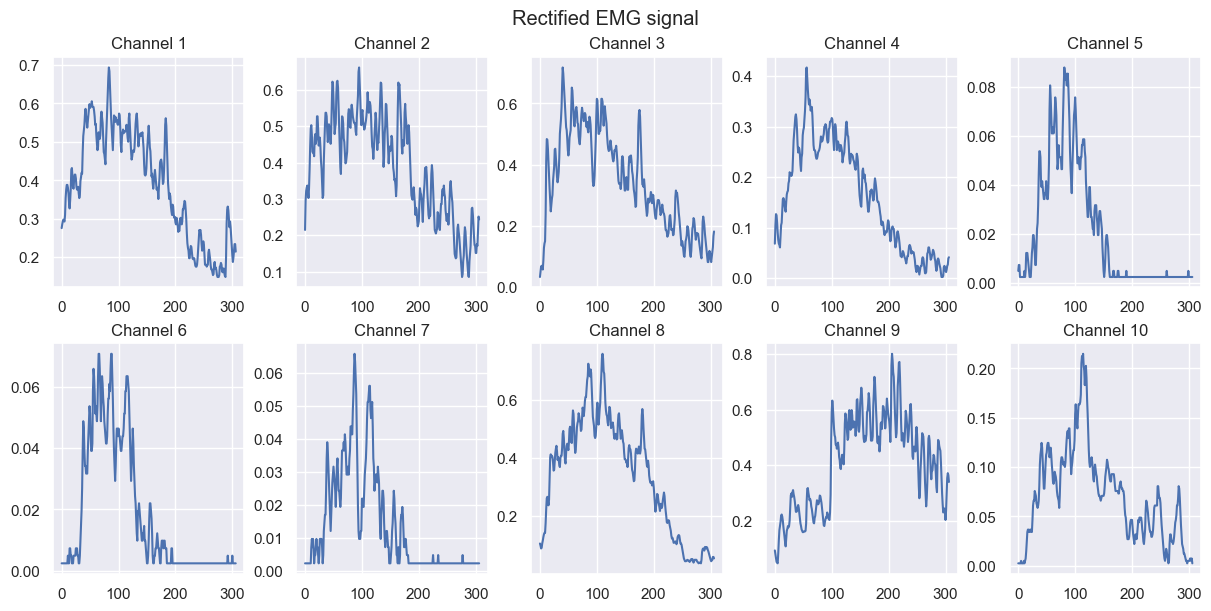

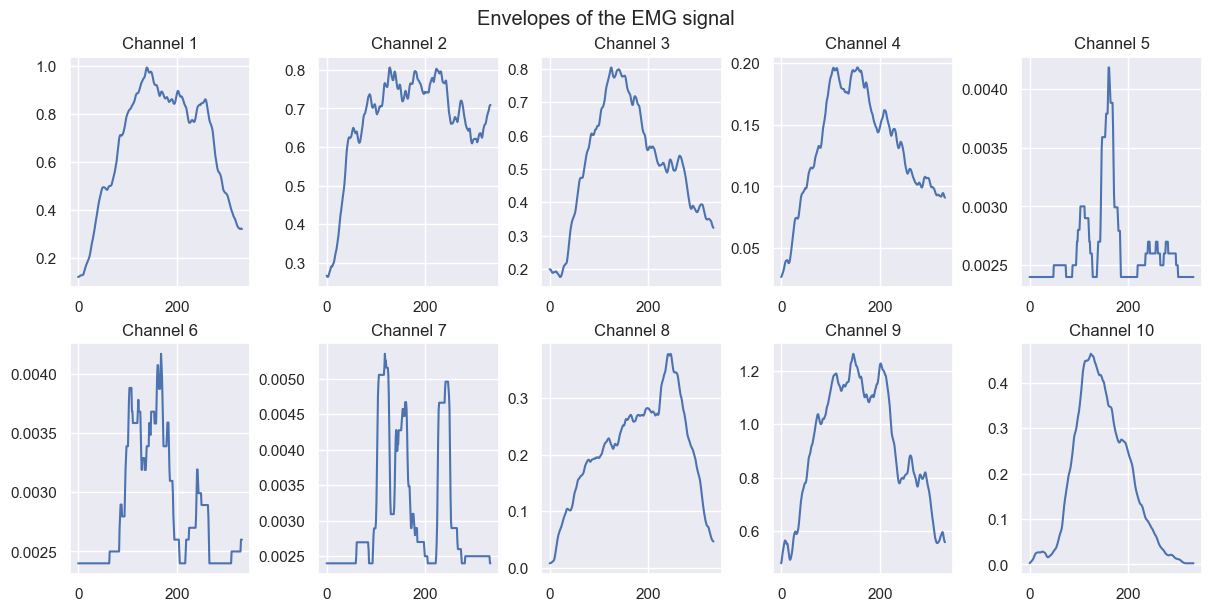

In [59]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

#10 EMG channels
number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[1][4][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

Text(0.5, 0.98, 'Envelopes of the EMG signal')

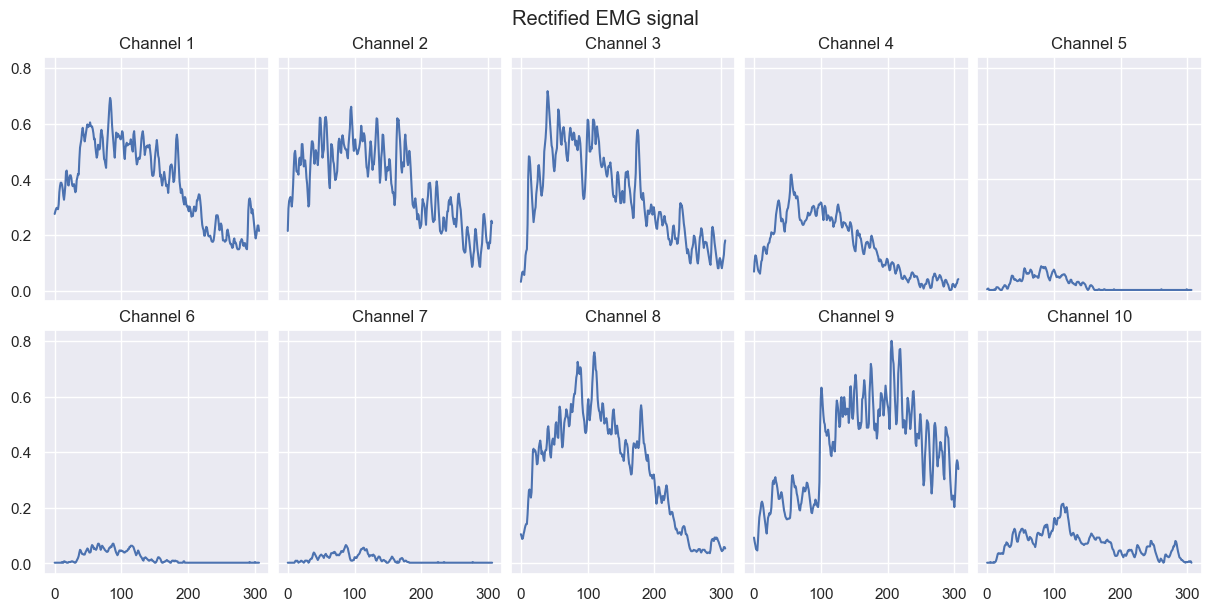

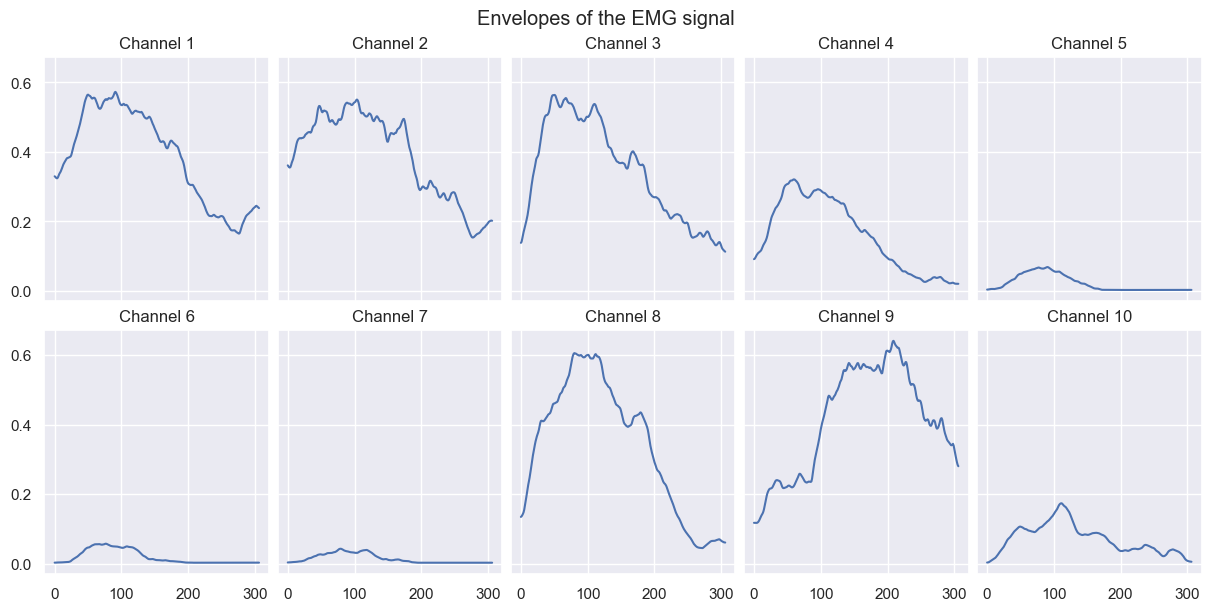

In [60]:
# Now we plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

Visualing the EMG envelopes accross all trials for a given action

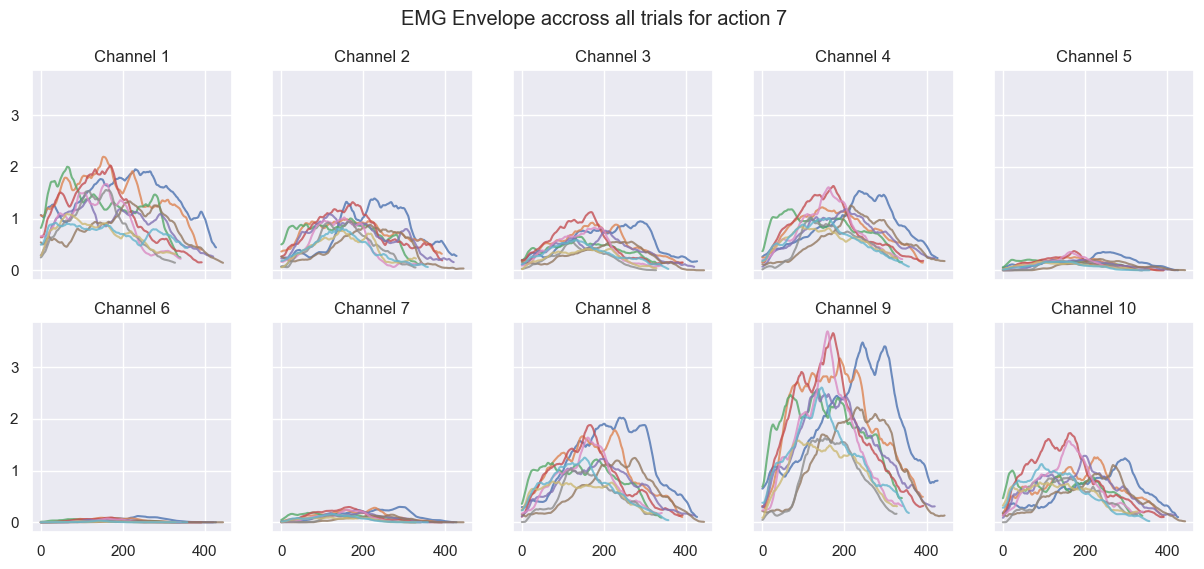

In [61]:
action_idx = 6   # e.g. eighth action
num_trials = len(emg_windows[action_idx])
num_channels = emg_windows[action_idx][0].shape[-1]

fig, ax = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
ax = ax.ravel()

for ch in range(num_channels):
    for trial in range(num_trials):
        ax[ch].plot(emg_envelopes[action_idx][trial][:, ch], alpha=0.8)
    ax[ch].set_title(f"Channel {ch+1}")

plt.suptitle(f"EMG Envelope accross all trials for action {action_idx + 1}")
plt.show()


In [62]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

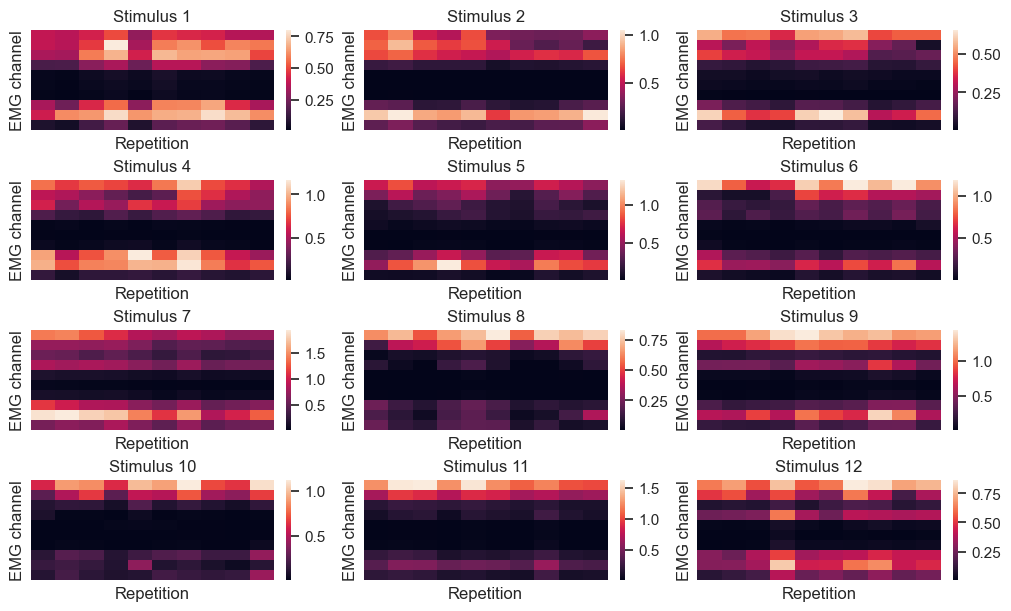

In [63]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

In [64]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

## Feature extraction

In [65]:
import numpy as np

# Si emg_envelopes est une liste de listes : [[array(...), ...], [...], ...]
all_segments = [seg for row in emg_envelopes for seg in row]

emg_stacked = np.vstack(all_segments)
print(emg_stacked.shape)   # (N_total, 10) normalement



(41791, 10)


In [66]:
emg_rectified

array([[0.0269, 0.1001, 0.0024, ..., 0.0024, 0.0024, 0.0024],
       [0.0269, 0.0757, 0.0024, ..., 0.0024, 0.0024, 0.0024],
       [0.0317, 0.0586, 0.0024, ..., 0.0024, 0.0024, 0.0024],
       ...,
       [0.1978, 0.3101, 0.0366, ..., 0.0049, 0.0024, 0.0024],
       [0.1978, 0.2832, 0.0317, ..., 0.0024, 0.0024, 0.0024],
       [0.1953, 0.3052, 0.0317, ..., 0.0049, 0.0024, 0.0024]])

In [67]:
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
# Sum of absolute differences between consecutive samples
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

features = [mav, std, maxav, rms, wl, ssc]

dataset, labels = build_dataset_from_ninapro(
    emg=emg_rectified,
    stimulus=stimulus,
    repetition=repetition,
    features=features  # or [mav, std] if you're starting simple
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")


dataset dimension: (120, 60)
labels dimension: (120,)


In [68]:
feature_names = ["Mean absolute value", "Standard Deviation", "Maximum absolute value", "Root mean square", "Waveform length", "Sum of absolute differences"]

In [69]:
n_trials   = dataset.shape[0]
n_features = len(feature_names)
n_channels = emg_rectified.shape[1]

# (trials, features, channels)
data_reshaped = dataset.reshape(n_trials, n_features, n_channels)

labels_int    = labels.astype(int)
unique_labels = np.unique(labels_int)
n_movements   = len(unique_labels)

# means[feature, channel, movement]
means = np.zeros((n_features, n_channels, n_movements))

for fi in range(n_features):
    for mi, mov in enumerate(unique_labels):
        mask = labels_int == mov                  # trials of this movement
        # average over trials -> one value per channel
        means[fi, :, mi] = data_reshaped[mask, fi, :].mean(axis=0)


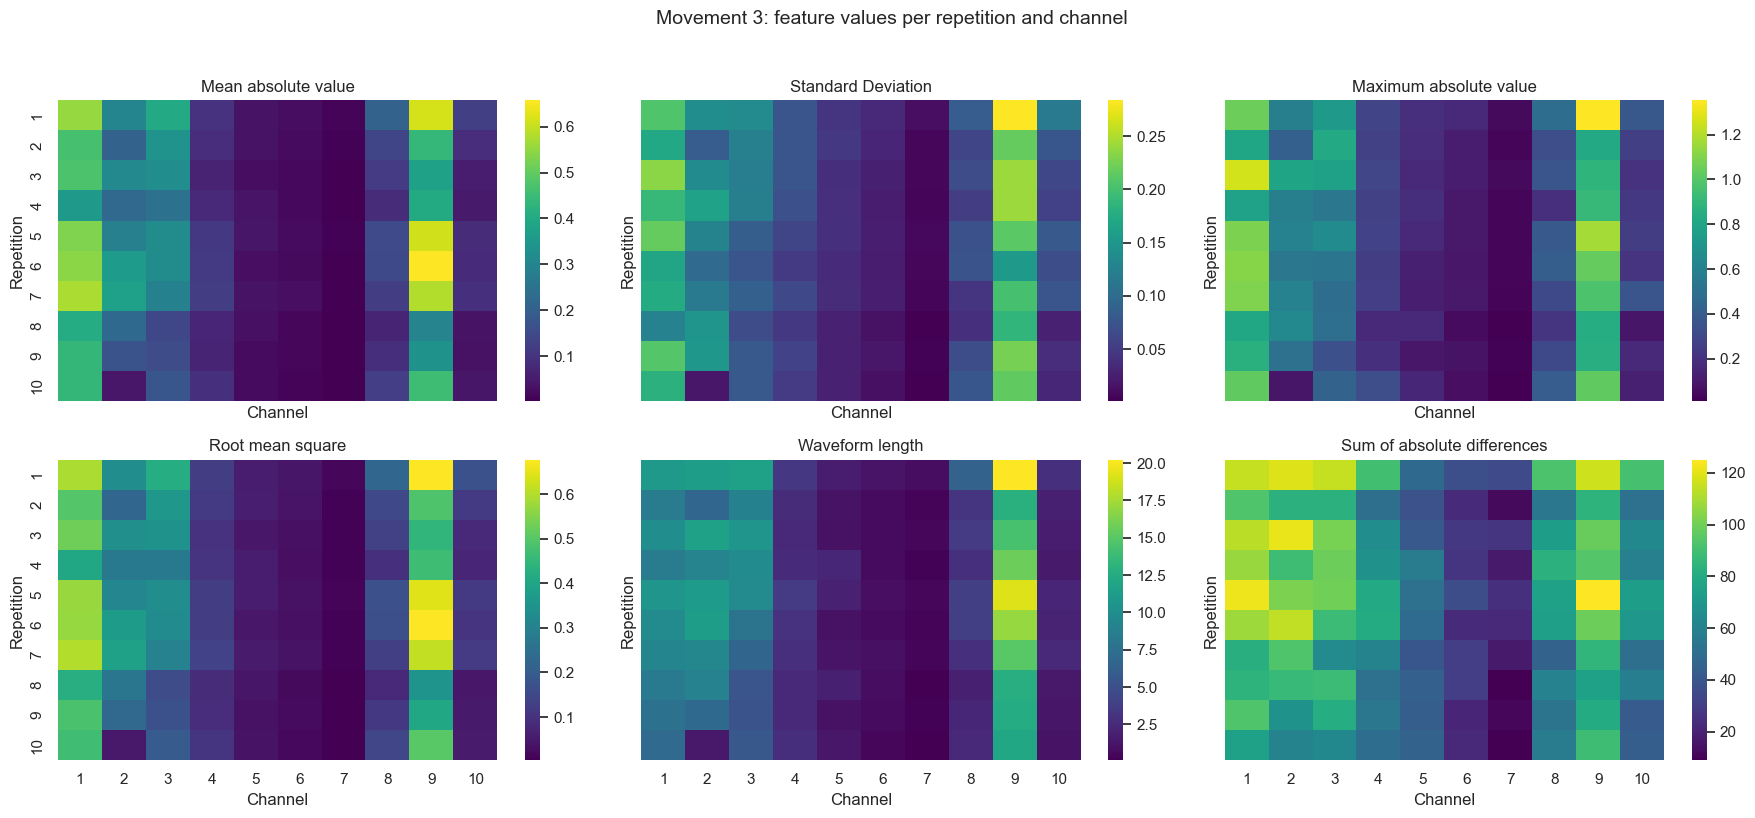

In [70]:
# ----- choose movement (label) -----
movement_to_plot = 3          # <-- set this to the movement you want

labels_int   = labels.astype(int)
n_trials     = dataset.shape[0]
n_features   = len(feature_names)
n_channels   = emg_rectified.shape[1]

# reshape: (trials, features, channels)
data_reshaped = dataset.reshape(n_trials, n_features, n_channels)

# trials (repetitions) for this movement
mask      = labels_int == movement_to_plot
reps_data = data_reshaped[mask, :, :]          # shape: (n_reps, n_features, n_channels)

n_reps = reps_data.shape[0]

# ----- 6 heatmaps: rows = reps (1..n_reps), cols = channels (1..n_channels) -----
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.ravel()

for fi, ax in enumerate(axes):
    # matrix for this feature: (reps, channels)
    mat = reps_data[:, fi, :]   # shape (n_reps, n_channels)

    sns.heatmap(
        mat,
        ax=ax,
        cmap="viridis",
        cbar=True,
        xticklabels=np.arange(1, n_channels + 1),
        yticklabels=np.arange(1, n_reps + 1)
    )
    ax.set_title(feature_names[fi])
    ax.set_xlabel("Channel")
    ax.set_ylabel("Repetition")

fig.suptitle(f"Movement {movement_to_plot}: feature values per repetition and channel",
             y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


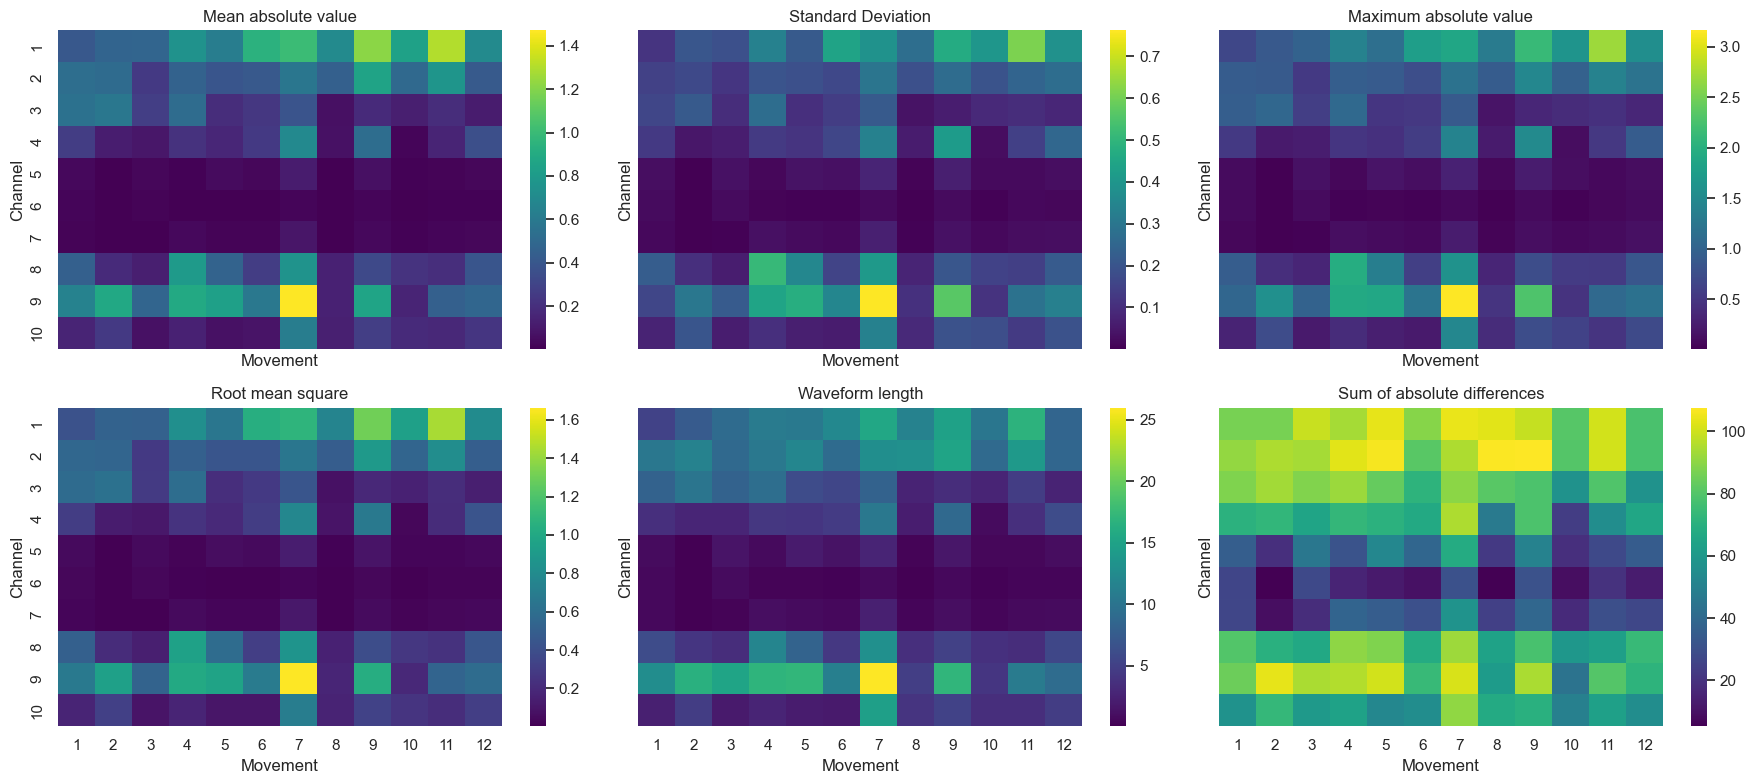

In [71]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.ravel()

for fi, ax in enumerate(axes):
    sns.heatmap(
        means[fi, :, :],          # shape (channels, movements)
        ax=ax,
        cmap="viridis",
        cbar=True
    )
    ax.set_title(feature_names[fi])

    ax.set_xlabel("Movement")
    ax.set_ylabel("Channel")

    ax.set_xticks(np.arange(n_movements) + 0.5)
    ax.set_xticklabels(unique_labels)

    ax.set_yticks(np.arange(n_channels) + 0.5)
    ax.set_yticklabels(np.arange(1, n_channels + 1))

plt.tight_layout()
plt.show()


## Data splitting into train set, test set and validation set

In [72]:
# 1) Train / temp split (temp will be split into val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    dataset,
    labels,
    test_size=0.4,          # 40% goes to val+test
    random_state=0,
    stratify=labels         # keep class proportions
)

# 2) Validation / test split (from the temp set)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,          # half of the 40% → 20% test, 20% val
    random_state=0,
    stratify=y_temp
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (72, 60), Val: (24, 60), Test: (24, 60)


## Model fitting

Validation accuracy: 0.667
Test accuracy: 0.625


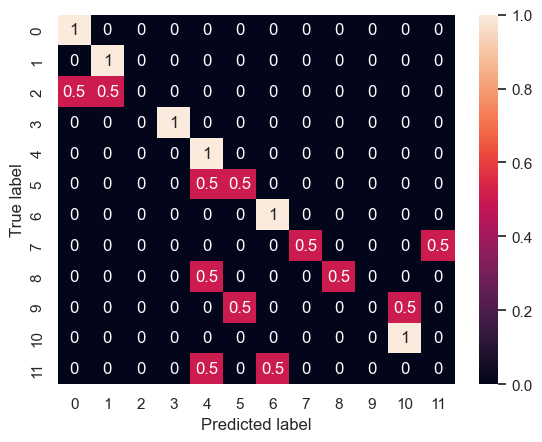

In [73]:
# Normalizing the data 
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z   = scaler.transform(X_val)
X_test_z  = scaler.transform(X_test)


# Train a Gradient Boosting classifier on the normalized data
clf = GradientBoostingClassifier(
    n_estimators=100,      # number of trees
    learning_rate=0.1,    # step size
    max_depth=3,          # depth of individual trees
    random_state=0
)
clf.fit(X_train_z, y_train)

# 5) Evaluate on validation and test sets
y_val_pred = clf.predict(X_val_z)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.3f}")

y_test_pred = clf.predict(X_test_z)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_acc:.3f}")

# Confusion matrix on test set
confmat = confusion_matrix(y_test, y_test_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label");


## Hyperparameter optimization

In [178]:
# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.6, 0.8],
}

# Generate all combinations
param_combinations = list(itertools.product(*param_grid.values()))

best_params = None
best_val_acc = -1

print(f"Total combinations: {len(param_combinations)}\n")

# Loop with tqdm progress bar
for params in tqdm(param_combinations, desc="Hyperparameter search"):
    
    # Convert tuple → dict
    params_dict = dict(zip(param_grid.keys(), params))

    # Train on training set
    model = GradientBoostingClassifier(
        random_state=42,
        **params_dict
    )
    model.fit(X_train_z, y_train)

    # Validate on validation set
    y_val_pred = model.predict(X_val_z)
    val_acc = accuracy_score(y_val, y_val_pred)

    # Track best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params_dict

# Print results
print("\nBest hyperparameters:", best_params)
print("Best validation accuracy:", best_val_acc)


Total combinations: 54



Hyperparameter search: 100%|██████████| 54/54 [00:48<00:00,  1.11it/s]


Best hyperparameters: {'n_estimators': 50, 'learning_rate': 0.01, 'max_depth': 2, 'subsample': 0.6}
Best validation accuracy: 0.9583333333333334


## Model evaluation

Final test accuracy: 0.7500


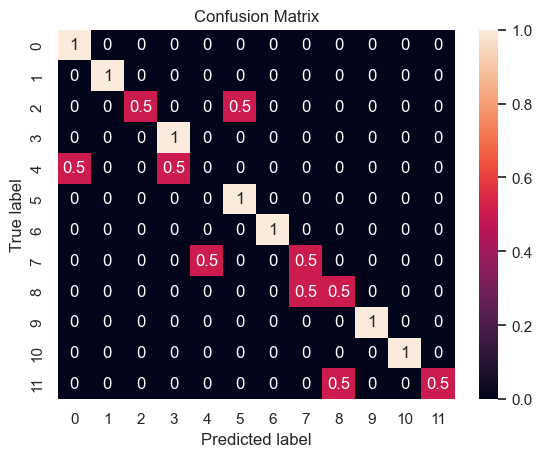

In [181]:
final_model = GradientBoostingClassifier(
    random_state=42,
    **best_params
)
final_model.fit(X_train_z, y_train)

y_test_pred = final_model.predict(X_test_z)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Final test accuracy: {test_acc:.4f}")

confmat = confusion_matrix(y_test, y_test_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.savefig(f"Confusion_Matrix.png")


## Feature selection/ Dimension reduction 

### For feature selection , we will try out : 
### 1) ANOVA F test 
### 2) Mutual Information 
using sklearn SelectKbest 

In [158]:
n_features = X_train_z.shape[1]

This function defines the same hyperparameter optimization pipeline and metric as the part 5.

In [161]:
def hyperparam_GB(
    X_train_z, y_train,
    X_val_z, y_val,
    score_func,
    k_list,
    gb_param_grid,
    random_state=42
):
    gb_keys = list(gb_param_grid.keys())
    gb_combos = list(itertools.product(*gb_param_grid.values()))

    best_val_acc = -1
    best_params = None
    best_val_by_k = []

    print(f"Total combinations: {len(k_list) * len(gb_combos)}")

    for k in tqdm(k_list, desc="Scanning k"):
        k_val = X_train_z.shape[1] if k == "all" else k
        selector = SelectKBest(score_func=score_func, k=k_val)
        
        Xtr_sel = selector.fit_transform(X_train_z, y_train)
        Xva_sel = selector.transform(X_val_z)

        best_val_acc_k = -1 

        for gb_tuple in gb_combos:
            gb_params = dict(zip(gb_keys, gb_tuple))
            clf = GradientBoostingClassifier(random_state=random_state, **gb_params)
            clf.fit(Xtr_sel, y_train)

            val_acc = accuracy_score(y_val, clf.predict(Xva_sel))

            if val_acc > best_val_acc_k:
                best_val_acc_k = val_acc

            if val_acc > best_val_acc:
                best_val_acc = val_acc

                best_params = {"k": k_val, "gb_params": gb_params}

        best_val_by_k.append(best_val_acc_k)

    
    # Combine the train and validation datasets to leverage all available data
    X_combined = np.vstack((X_train_z, X_val_z))
    y_combined = np.concatenate((y_train, y_val))
    
    # Initialize the best selector and model found
    final_selector = SelectKBest(score_func=score_func, k=best_params["k"])
    final_model = GradientBoostingClassifier(random_state=random_state, **best_params["gb_params"])
    
    # Fit on the full combined transformed dataset
    X_combined_sel = final_selector.fit_transform(X_combined, y_combined)
    final_model.fit(X_combined_sel, y_combined)

    return final_selector, final_model, best_params, best_val_acc, best_val_by_k

The following functions are made for visualization 

In [162]:
def plot_val_accuracy_vs_k(
    k_list,
    best_val_by_k,
    n_features= n_features,
):
    """
    Plots best validation accuracy vs number of selected features.
    Highlights:
      - best overall k (star)
      - k = 'all' (diamond), if present

    Parameters
    ----------
    k_list : list
        List of k values tested (may include 'all')
    best_val_by_k : list or array
        Best validation accuracy for each k (same order as k_list)
    n_features : int
        Total number of features (used to replace 'all')
    title : str
        Plot title
    """

    # Convert k_list to numeric for plotting
    k_vals = [n_features if k == "all" else int(k) for k in k_list]
    best_val_arr = np.asarray(best_val_by_k, dtype=float)

    if len(k_vals) != len(best_val_arr):
        raise ValueError("k_list and best_val_by_k must have the same length")

    # Indices
    best_i = int(np.argmax(best_val_arr))
    idx_all = k_list.index("all") if "all" in k_list else None

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(
        k_vals,
        best_val_arr,
        marker="o",
        linewidth=2,
        label="Best validation accuracy"
    )

    # Highlight best overall k
    plt.scatter(
        k_vals[best_i],
        best_val_arr[best_i],
        marker="*",
        s=160,
        zorder=5,
        label=f"Best k = {k_vals[best_i]}"
    )

    plt.annotate(
        f"{best_val_arr[best_i]:.3f}",
        (k_vals[best_i], best_val_arr[best_i]),
        textcoords="offset points",
        xytext=(0, 8),
        ha="center",
        fontsize=9,
        fontweight="bold"
    )

    # Highlight k = all
    if idx_all is not None:
        plt.scatter(
            k_vals[idx_all],
            best_val_arr[idx_all],
            marker="D",
            s=90,
            zorder=4,
            label="k = all"
        )

        plt.annotate(
            f"{best_val_arr[idx_all]:.3f}",
            (k_vals[idx_all], best_val_arr[idx_all]),
            textcoords="offset points",
            xytext=(0, -14),
            ha="center",
            fontsize=9
        )

    plt.xlabel("Number of selected features (k)")
    plt.ylabel("Best validation accuracy")
    plt.title("Validation accuracy vs number of selected features")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [163]:
def CM_plot(y_test, y_pred, titre):    
    confmat = confusion_matrix(y_test, y_pred, normalize="true")
    fig, ax = plt.subplots()
    sns.heatmap(confmat, annot=True, ax=ax)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    plt.title("Confusion Matrix" + titre)
    plt.savefig(f"Confusion_Matrix_{titre}.png")

In [164]:
feature_types = ["MAV", "STD", "RMS", "maxav", "WL", "SSC"]  
n_channels = 10
n_feat_per_channel = 6
feature_names = []
for ch in range(n_channels):
    for ftype in feature_types:
        feature_names.append(f"ch{ch+1}_{ftype}")

### 1) ANOVA F test 

Total combinations: 324


Scanning k: 100%|██████████| 6/6 [03:29<00:00, 34.86s/it]



[ANOVA] Best params: {'k': 20, 'gb_params': {'n_estimators': 50, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.8}}
[ANOVA] Best validation accuracy: 0.9583333333333334
Test accuracy score of ANOVA model with k = 20 best features: 0.7917


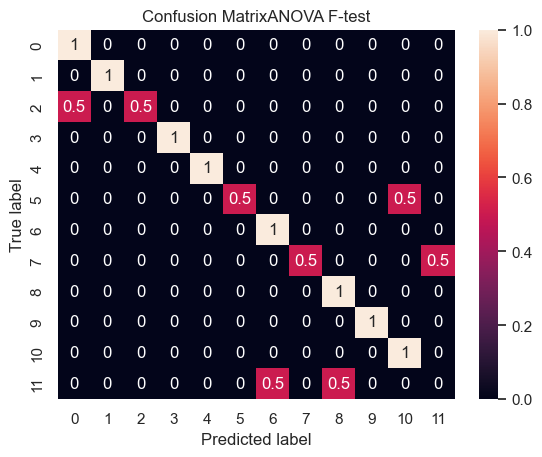

In [165]:
gb_param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.6, 0.8],
}

k_list = [10, 20, 30, 40, 50, "all"]

anova_select, model_anova, params_anova, best_val_anova, val_list_anova = hyperparam_GB(
    X_train_z, y_train,
    X_val_z, y_val,
    k_list=k_list,
    score_func=f_classif,
    gb_param_grid=gb_param_grid,
    random_state=42
)

print("\n[ANOVA] Best params:", params_anova)
print("[ANOVA] Best validation accuracy:", best_val_anova)

# Evaluate on test set
X_test_sel = anova_select.transform(X_test_z)
y_pred_anova = model_anova.predict(X_test_sel)
test_acc_anova = accuracy_score(y_test, y_pred_anova)
print(f"Test accuracy score of ANOVA model with k = {anova_select.k} best features: {test_acc_anova:.4f}")
CM_plot(y_test, y_pred_anova, "ANOVA F-test")


The confusion matrix obtained using ANOVA-selected features shows a strong diagonal dominance, indicating that most gesture classes are classified correctly with high confidence. Several classes achieve perfect classification (normalized accuracy = 1.0), reflecting that their EMG patterns are well captured by the univariate features selected through the F-test.
Some misclassifications are observed , where certain classes (e.g. labels 2, 5, 7, and 11) exhibit split predictions, where approximately half of the samples are assigned to a neighboring class.

In [166]:
mask_anova = anova_select.get_support().reshape(n_channels, n_feat_per_channel)
for ch in range(n_channels):
    selected_feats = [
        feature_types[j]
        for j, keep in enumerate(mask_anova[ch])
        if keep
    ]
    
    if selected_feats:
        print(f"Channel {ch+1}: {selected_feats}")
    else:
        print(f"Channel {ch+1}: None")

Channel 1: ['RMS', 'maxav', 'WL']
Channel 2: ['RMS', 'maxav']
Channel 3: ['MAV', 'STD']
Channel 4: ['WL', 'SSC']
Channel 5: None
Channel 6: ['RMS', 'maxav', 'WL']
Channel 7: ['STD', 'RMS', 'maxav']
Channel 8: ['STD', 'maxav', 'WL', 'SSC']
Channel 9: ['STD']
Channel 10: None


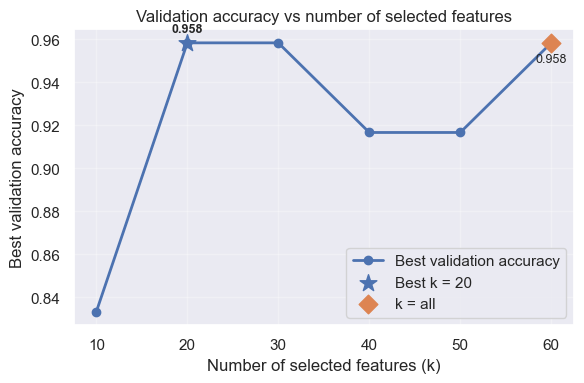

In [167]:
plot_val_accuracy_vs_k(k_list, val_list_anova)

Validation accuracy increases sharply from k = 10 to k = 20, where it reaches its maximum value (0.958). Increasing the number of selected features beyond this point does not improve performance. While using all features achieves a similar validation accuracy, intermediate values (k = 40–50) lead to a noticeable drop in performance. This indicates that a relatively small subset of features could be sufficient, and that including additional features can introduce redundancy without improving performance. The optimized model refit on training + validation set after feature selection was able to achieve a better test accuracy (~0.79) than the previous model (0.75).

### 2) Mutual information 

Total combinations: 324


Scanning k: 100%|██████████| 6/6 [03:42<00:00, 37.12s/it]



[MI] Best params: {'k': 30, 'gb_params': {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 2, 'subsample': 0.6}}
[MI] Best validation accuracy: 0.9583333333333334
Test accuracy score of MI model with k = 30 best features: 0.8750


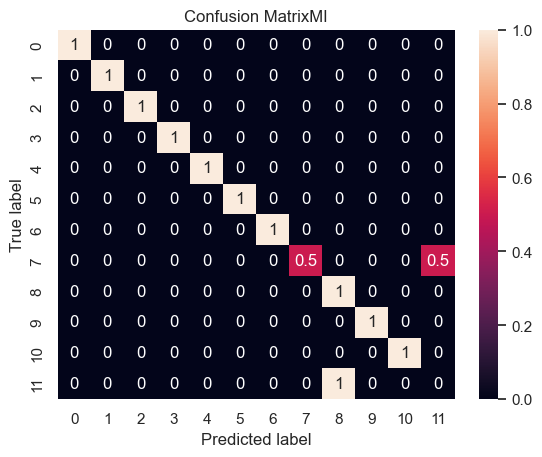

In [168]:
gb_param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.6, 0.8],
}

k_list = [10, 20, 30, 40, 50, "all"]

mi_select, model_mi, params_mi, best_val_mi, val_list_mi = hyperparam_GB(
    X_train_z, y_train,
    X_val_z, y_val,
    k_list=k_list,
    score_func=mutual_info_classif,
    gb_param_grid=gb_param_grid,
    random_state=0
)

print("\n[MI] Best params:", params_mi)
print("[MI] Best validation accuracy:", best_val_mi)

# Evaluate on test set
X_test_sel = mi_select.transform(X_test_z)
y_pred_mi = model_mi.predict(X_test_sel)
test_acc_mi = accuracy_score(y_test, y_pred_mi)
print(f"Test accuracy score of MI model with k = {mi_select.k} best features: {test_acc_mi:.4f}")
CM_plot(y_test, y_pred_mi, "MI")

The confusion matrix obtained using Mutual Information–based feature selection exhibits near-perfect diagonal dominance, indicating excellent class separability across almost all gestures. Compared to the ANOVA-based approach, the number of misclassifications is further reduced, with most classes achieving perfect classification (normalized accuracy = 1.0).

features that were selected with MI 

In [170]:
mask_mi = mi_select.get_support().reshape(n_channels, n_feat_per_channel)
for ch in range(n_channels):
    selected_feats = [
        feature_types[j]
        for j, keep in enumerate(mask_mi[ch])
        if keep
    ]
    
    if selected_feats:
        print(f"Channel {ch+1}: {selected_feats}")
    else:
        print(f"Channel {ch+1}: None")

Channel 1: ['RMS', 'maxav', 'WL']
Channel 2: ['MAV', 'RMS', 'maxav', 'WL']
Channel 3: ['MAV', 'STD', 'RMS', 'WL']
Channel 4: ['MAV', 'RMS', 'SSC']
Channel 5: ['MAV', 'maxav', 'WL', 'SSC']
Channel 6: ['RMS', 'maxav', 'WL']
Channel 7: ['MAV', 'STD', 'RMS']
Channel 8: ['MAV', 'STD', 'RMS', 'maxav']
Channel 9: ['MAV']
Channel 10: ['MAV']


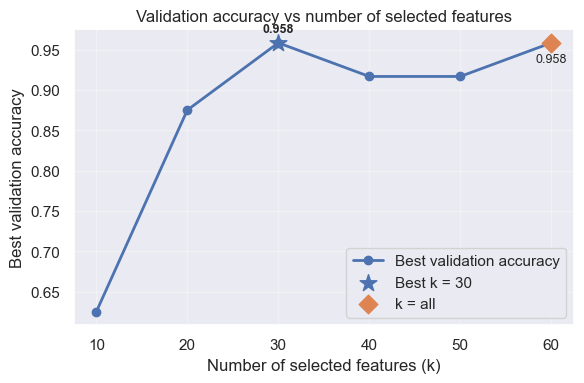

In [169]:
plot_val_accuracy_vs_k(
    k_list,
    val_list_mi
)

Similarly noted to ANOVA , the best validation accuracy (0.958) is achieved at k = 30, suggesting that this subset provides an optimal balance between information content and redundancy. Interestingly, using all available features achieves a validation accuracy comparable to the best subset, but does not provide a clear advantage over the reduced feature set. This confirms that many features can be redundant or weakly informative, and that effective feature selection can preserve performance while reducing dimensionality.
The MI model was able to achieve a better classification overall than the previous model, 0.875 compared to 0.75

### For dimension reduction , we'll use 1) PCA and 2) LDA 

### 1) Principal component analysis 

In [ ]:
pca_search = PCA(n_components=0.95) # retain 95% variance
X_train_pca = pca_search.fit_transform(X_train_z)
X_val_pca = pca_search.transform(X_val_z)

param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.6, 0.8],
}

param_combinations = list(itertools.product(*param_grid.values()))
param_pca = None
best_val_pca = -1

print(f"Searching {len(param_combinations)} combinations...")

for params in tqdm(param_combinations):
    params_dict = dict(zip(param_grid.keys(), params))
    
    model = GradientBoostingClassifier(random_state=42, **params_dict)
    model.fit(X_train_pca, y_train)

    y_val_pred = model.predict(X_val_pca)
    val_acc = accuracy_score(y_val, y_val_pred)

    if val_acc > best_val_pca:
        best_val_pca = val_acc
        param_pca = params_dict

print("\nBest hyperparameters:", param_pca)


# refitting on combined Train + Val
X_combined = np.vstack((X_train_z, X_val_z))
y_combined = np.concatenate((y_train, y_val))

final_pca = PCA(n_components=0.95)
X_combined_pca = final_pca.fit_transform(X_combined)
final_model_pca = GradientBoostingClassifier(random_state=42, **param_pca)
final_model_pca.fit(X_combined_pca, y_combined)

'''
final_pca = PCA(n_components=0.95)
X_train_pca = final_pca.fit_transform(X_train_z)
final_model_pca = GradientBoostingClassifier(random_state=42, **param_pca)
final_model_pca.fit(X_train_pca, y_train)
'''

Searching 54 combinations...


100%|██████████| 54/54 [00:21<00:00,  2.55it/s]



Best hyperparameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 2, 'subsample': 0.6}


'\nfinal_pca = PCA(n_components=0.95)\nX_train_pca = final_pca.fit_transform(X_train_z)\nfinal_model_pca = GradientBoostingClassifier(random_state=42, **param_pca)\nfinal_model_pca.fit(X_train_pca, y_train)\n'

Final test accuracy with PCA (11 components): 0.6250


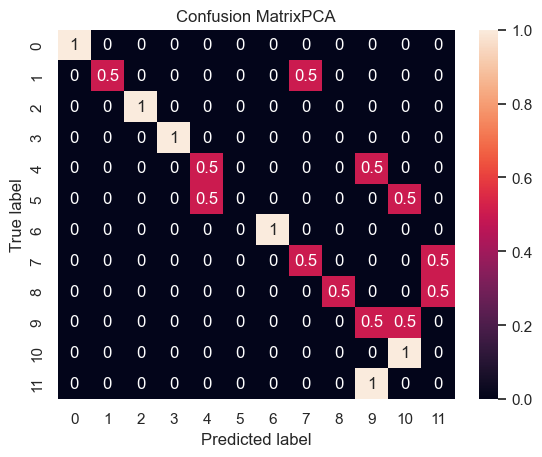

In [ ]:
X_test_pca = final_pca.transform(X_test_z)
y_pred_pca= final_model_pca.predict(X_test_pca)
test_acc_pca = accuracy_score(y_test, y_pred_pca)
print(f"Final test accuracy with PCA ({X_train_pca.shape[1]} components): {test_acc_pca:.4f}")
CM_plot(y_test, y_pred_pca, "PCA")

Using PCA-based dimensionality reduction, the model achieves a test accuracy of 0.625, which is substantially lower than the performance obtained with ANOVA and Mutual Information. The confusion matrix reflects this drop in performance, showing widespread off-diagonal entries.

Several classes are partially or fully confused with others, with multiple gestures exhibiting split predictions across different labels. Unlike ANOVA and MI, misclassifications are not limited to a small number of gesture pairs but are distributed across the matrix, indicating weaker class separability in the reduced feature space.

This behavior is expected for PCA, as it is an unsupervised method that maximizes variance without considering class labels. As a result, directions of high variance in the EMG data do not necessarily correspond to directions that are most discriminative for gesture classification.

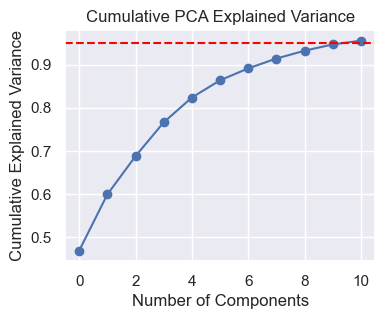

In [ ]:
var = final_pca.explained_variance_ratio_
plt.figure(figsize=(4,3))
plt.plot(np.cumsum(var), marker='o')
plt.axhline(0.95, color='red', linestyle='--') 
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative PCA Explained Variance")
plt.grid(True)
plt.show()

### 2) Linear Discriminant Analysis

In [174]:
lda_search = LDA() 
X_train_lda = lda_search.fit_transform(X_train_z, y_train)
X_val_lda = lda_search.transform(X_val_z)

print(f"Original features: {X_train_z.shape[1]}")
print(f"Reduced features (LDA): {X_train_lda.shape[1]}") 
# LDA reduces to at most (n_classes - 1) components

param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.6, 0.8],
}

param_combinations = list(itertools.product(*param_grid.values()))
param_lda = None
best_val_lda = -1

print(f"Searching {len(param_combinations)} combinations...\n")

for params in tqdm(param_combinations, desc="LDA Search"):
    params_dict = dict(zip(param_grid.keys(), params))
    
    model = GradientBoostingClassifier(random_state=42, **params_dict)
    model.fit(X_train_lda, y_train)

    y_val_pred = model.predict(X_val_lda)
    val_acc = accuracy_score(y_val, y_val_pred)

    if val_acc > best_val_lda:
        best_val_lda = val_acc
        param_lda = params_dict

print("\nBest hyperparameters:", param_lda)

# Combine Training and Validation sets
X_combined = np.vstack((X_train_z, X_val_z))
y_combined = np.concatenate((y_train, y_val))

X_combined_lda = lda_search.transform(X_combined) 

final_model_lda = GradientBoostingClassifier(random_state=42, **param_lda)
final_model_lda.fit(X_combined_lda, y_combined)


Original features: 60
Reduced features (LDA): 11
Searching 54 combinations...



LDA Search: 100%|██████████| 54/54 [00:20<00:00,  2.65it/s]



Best hyperparameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'subsample': 0.6}


GradientBoostingClassifier(max_depth=4, random_state=42, subsample=0.6)

Final Test Accuracy: 0.6667


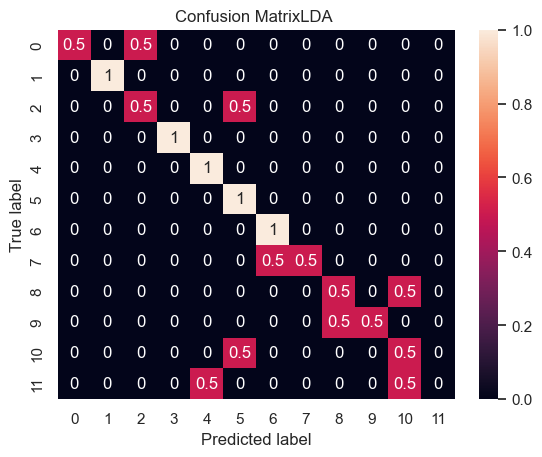

In [175]:
X_test_lda = lda_search.transform(X_test_z)
y_pred_lda = final_model_lda.predict(X_test_lda)
test_acc_lda = accuracy_score(y_test, y_pred_lda)
print(f"Final Test Accuracy: {test_acc_lda:.4f}")
CM_plot(y_test, y_pred_lda, "LDA ")

Using Linear Discriminant Analysis, the model achieves a test accuracy of 0.6667, which improves upon PCA but remains well below the performance obtained with ANOVA and Mutual Information. The confusion matrix shows a partial recovery of diagonal structure, with several classes correctly classified, but still exhibits multiple off-diagonal confusions.

Misclassifications are concentrated among specific gesture groups, with several classes showing split predictions across two labels, suggesting that the reduced LDA feature space does not fully preserve the discriminative information needed for reliable gesture classification. 

Overall, LDA provides moderate performance, improving over unsupervised dimensionality reduction but remaining less effective than feature selection methods.

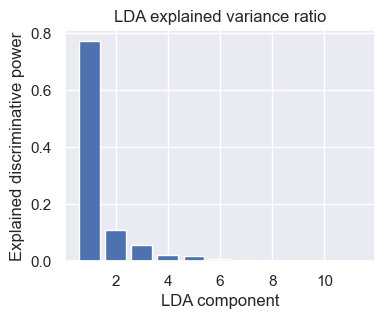

In [176]:
evr = lda_search.explained_variance_ratio_ 
plt.figure(figsize=(4,3))
plt.bar(range(1, len(evr)+1), evr)
plt.xlabel("LDA component")
plt.ylabel("Explained discriminative power")
plt.title("LDA explained variance ratio")
plt.show()

### Comparing the performance of the models

Summarizing the results found from initial model training to feature selection and dimension reduction.

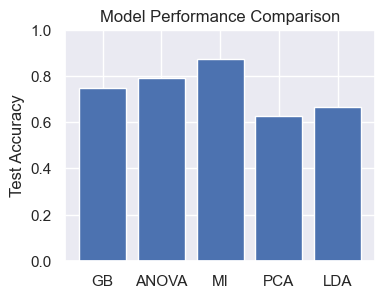

In [ ]:
accuracies = {
    "GB": test_acc,
    "ANOVA": test_acc_anova,
    "MI": test_acc_mi,
    "PCA": test_acc_pca,
    "LDA": test_acc_lda
}

plt.figure(figsize=(4,3))
plt.bar(accuracies.keys(), accuracies.values())

plt.ylabel("Test Accuracy")
plt.ylim(0, 1)
plt.title("Model Performance Comparison")
plt.show()